In [6]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
import os

In [40]:
################################'Generate X and Y'##############################
################################ Xt = α + βXt-1 + εt
################################ Yt = α + βYt-1 + γXt + εt + θεt-1

def generate_data(T, alpha, beta, sigma, alpha_y, beta_y, gamma, theta, sigma_y, mu):
    df = pd.DataFrame(index=range(T), columns=['x', 'y', 'epsilon_x', 'epsilon_y'])
    x1 = alpha/(1-beta) # define initial value for time series x
    y1 = 0
    epsilon_x = sigma*np.random.randn(T) + mu # generate a vector of T random normal
    epsilon_y = sigma_y*np.random.randn(T) # generate a vector of T random normal
    
    df.iloc[0,:] = [x1, y1, np.nan, np.nan] # initialize x and y
    
    for i in range(0, T-1):
        df.iloc[i+1,0] = alpha + beta * df.iloc[i,0] + epsilon_x[i+1] # generate X(t) recursively
            # Xt = α + βXt-1 + εt
        df.iloc[i+1,1] = alpha_y + beta_y * df.iloc[i,1] + gamma * df.iloc[i+1,0] + epsilon_y[i+1] + theta * epsilon_y[i] # generate Y(t) recursively
            # Yt = α + βYt-1 + γXt + εt + θεt-1
        df.iloc[i+1,2] = epsilon_x[i+1] # associate error with X(t)
        df.iloc[i+1,3] = epsilon_y[i+1] # associate error with Y(t)
    
    return df


In [50]:
##generate_data(T, alpha, beta, sigma, alpha_y, beta_y, gamma, theta, sigma_y, mu)
#df = generate_data(1000, 1, 0.9, 3, 6, 0.3, 0.9, 0.9, 8, 1.7) i+uncomment to make like sim5
df = generate_data(1000, 1, 0.9, 0.1, 1, 0.9, 0.9, 0.5, 0.1, 0)

In [51]:
# Drop the first row and create a new dataframe
new_df = df.iloc[1:, :]

In [52]:
################################ Quantile linear with package ################################
def fit_quantile(df, alpha_y, beta_y, gamma):
    # Fit quantile regression at the specified quantile
    y = df['y'].values.astype(float)
    x = df['x'].values.astype(float)
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    
    quant_reg_1 = sm.QuantReg(y, alpha_y + beta_y * y_lag + gamma * x).fit(q=0.1)
    quant_reg_5 = sm.QuantReg(y, alpha_y + beta_y * y_lag + gamma * x).fit(q=0.5)
    quant_reg_9 = sm.QuantReg(y, alpha_y + beta_y * y_lag + gamma * x).fit(q=0.9)
    # Yt = α + βYt-1 + γXt 

# Plot the quantile regression lines at different quantile levels
    # Create a scatter plot of the data
    plt.scatter(x, y, alpha=0.5)
    x_sort = np.sort(x)
    y_pred_1 = quant_reg_1.predict(x_sort)
    y_pred_5 = quant_reg_5.predict(x_sort)
    y_pred_9 = quant_reg_9.predict(x_sort)

    plt.plot(x_sort, y_pred_1, color='red', label='Quantile level: 0.1')
    plt.plot(x_sort, y_pred_5, color='green', label='Quantile level: 0.5')
    plt.plot(x_sort, y_pred_9, color='blue', label='Quantile level: 0.9')

    # Add a legend and labels to the plot
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Quantile regression at different quantile levels')
    plt.show()

    ################################ Autocorrelation of the residuals ##############################
    residuals_1 = quant_reg_1.resid # Calculate the residuals
    residuals_5 = quant_reg_5.resid # Calculate the residuals
    residuals_9 = quant_reg_9.resid # Calculate the residuals

    # Plot the autocorrelation function of the residuals for all three quantile regression models in one plot
    fig, ax = plt.subplots(3, 1, figsize=(8, 10))
    plot_acf(quant_reg_1.resid, ax=ax[0])
    ax[0].set_title('Autocorrelation of residuals (quantile level = 0.1)')
    plot_acf(quant_reg_5.resid, ax=ax[1])
    ax[1].set_title('Autocorrelation of residuals (quantile level = 0.5)')
    plot_acf(quant_reg_9.resid, ax=ax[2])
    ax[2].set_title('Autocorrelation of residuals (quantile level = 0.9)')
    plt.tight_layout()
    plt.show()


    return quant_reg_1.summary(), quant_reg_5.summary(), quant_reg_9.summary()

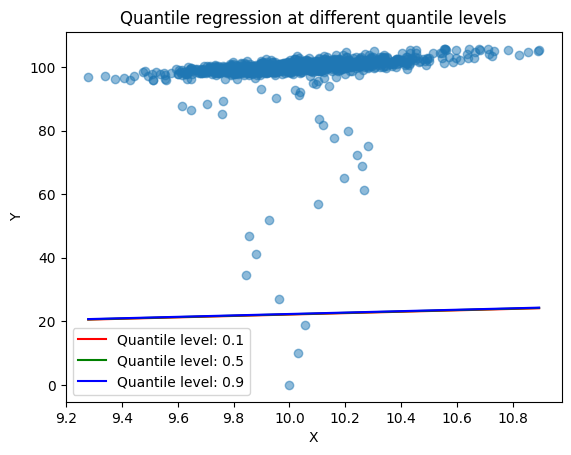

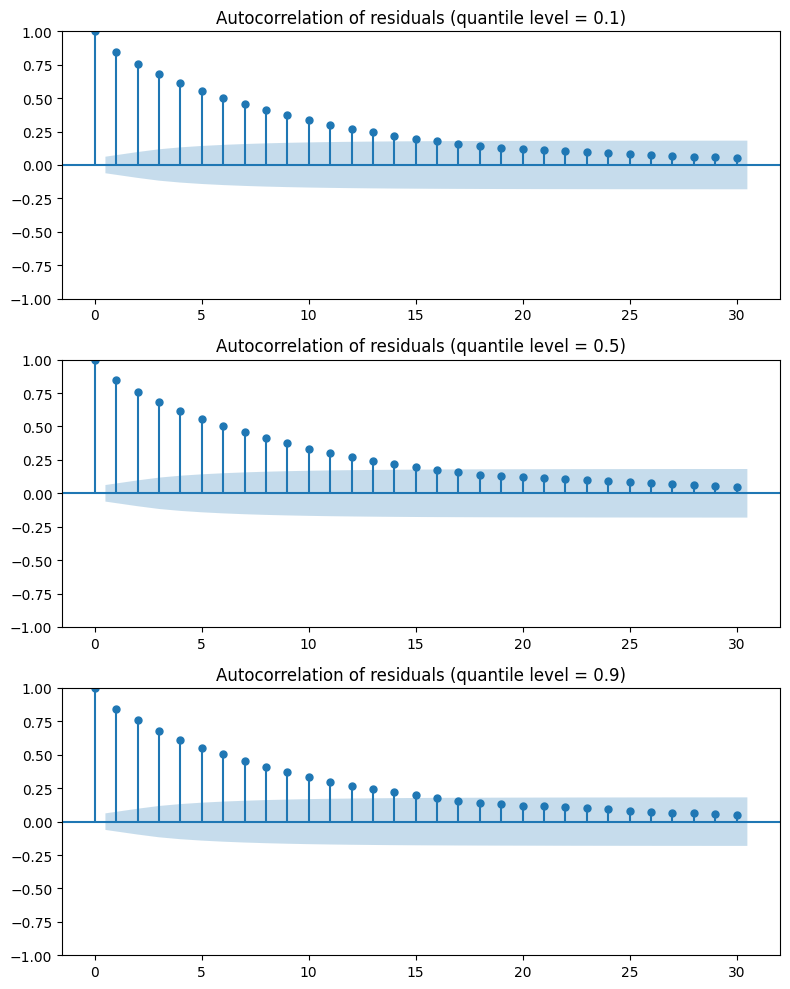

(<class 'statsmodels.iolib.summary.Summary'>
 """
                          QuantReg Regression Results                          
 Dep. Variable:                      y   Pseudo R-squared:               0.7420
 Model:                       QuantReg   Bandwidth:                      0.1293
 Method:                 Least Squares   Sparsity:                        1.942
 Date:                Fri, 21 Apr 2023   No. Observations:                 1000
 Time:                        11:52:04   Df Residuals:                      999
                                         Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
 ------------------------------------------------------------------------------
 x1             2.2131      0.000   5493.201      0.000       2.212       2.214
 """,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                          QuantReg Regression Results                          
 Dep. Variable

In [53]:
fit_quantile(df, 6, 0.3, 0.9)

In [38]:
def ols_gls_estimation(df):
    # convert data to float64 data type
    df = df.astype('float64')
    
    # extract data
    x = df['x'].values
    y = df['y'].values
    epsilon_y = df['epsilon_y'].values
    T = len(y)
    
    # OLS estimation of the parameters
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    epsilon_lag = np.roll(epsilon_y, 1)
    epsilon_lag[0] = 0
    X = np.column_stack((np.ones_like(x), y_lag, x, epsilon_lag))
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    print("OLS parameter estimates:")
    print("alpha_hat = {:.4f}".format(beta_hat[0]))
    print("beta_hat = {:.4f}".format(beta_hat[1]))
    print("gamma_hat = {:.4f}".format(beta_hat[2]))
    print("theta_hat = {:.4f}".format(beta_hat[3]))
    
    # GLS estimation of the parameters
    resid = y - X @ beta_hat
    acf_resid, ci = sm.tsa.stattools.acf(resid, nlags=10, alpha=0.05)
    sigma2 = np.var(resid) * (1 - acf_resid[1])
    sigma2_array = np.full(T, sigma2)
    rho = acf_resid[1] / (1 - acf_resid[1])
    S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
    beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
    print("GLS parameter estimates:")
    print("alpha_hat = {:.4f}".format(beta_gls[0]))
    print("beta_hat = {:.4f}".format(beta_gls[1]))
    print("gamma_hat = {:.4f}".format(beta_gls[2]))
    print("theta_hat = {:.4f}".format(beta_gls[3]))


In [33]:
ols_gls_estimation(new_df)

OLS parameter estimates:
alpha_hat = 1.0504
beta_hat = 0.8998
gamma_hat = 0.8970
theta_hat = 0.5455
GLS parameter estimates:
alpha_hat = 1.0502
beta_hat = 0.8998
gamma_hat = 0.8970
theta_hat = 0.5478


In [54]:
def ols_gls_estimation(df, quantiles):
    # convert data to float64 data type
    df = df.astype('float64')
    
    # extract data
    x = df['x'].values
    y = df['y'].values
    epsilon_y = df['epsilon_y'].values
    T = len(y)
    
    # OLS estimation of the parameters
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    epsilon_lag = np.roll(epsilon_y, 1)
    epsilon_lag[0] = 0
    X = np.column_stack((np.ones_like(x), y_lag, x, epsilon_lag))
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    print("OLS parameter estimates:")
    print("alpha_hat = {:.4f}".format(beta_hat[0]))
    print("beta_hat = {:.4f}".format(beta_hat[1]))
    print("gamma_hat = {:.4f}".format(beta_hat[2]))
    print("theta_hat = {:.4f}".format(beta_hat[3]))
    
    # GLS estimation of the parameters
    resid = y - X @ beta_hat
    acf_resid, ci = sm.tsa.stattools.acf(resid, nlags=10, alpha=0.05)
    sigma2 = np.var(resid) * (1 - acf_resid[1])
    sigma2_array = np.full(T, sigma2)
    rho = acf_resid[1] / (1 - acf_resid[1])
    S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
    
    for q in quantiles:
        # Estimate quantile regression parameters
        model = sm.QuantReg(y, X)
        quantile = model.fit(q=q)
        beta_qr = quantile.params
        
        # Calculate standard errors for quantile regression parameters
        cov_qr = quantile.cov_params()
        se_qr = np.sqrt(np.diag(cov_qr))
        
        # Calculate t-values and p-values for quantile regression parameters
        t_qr = beta_qr / se_qr
        p_qr = 2 * (1 - t.cdf(np.abs(t_qr), T - X.shape[1]))
        
        print(f"{q}-th Quantile regression parameter estimates:")
        print("alpha_hat = {:.4f}, SE = {:.4f}, t-value = {:.4f}, p-value = {:.4f}".format(beta_qr[0], se_qr[0], t_qr[0], p_qr[0]))
        print("beta_hat = {:.4f}, SE = {:.4f}, t-value = {:.4f}, p-value = {:.4f}".format(beta_qr[1], se_qr[1], t_qr[1], p_qr[1]))
        print("gamma_hat = {:.4f}, SE = {:.4f}, t-value = {:.4f}, p-value = {:.4f}".format(beta_qr[2], se_qr[2], t_qr[2], p_qr[2]))
       


In [55]:
quantiles = 0.1, 0.5, 0.9
ols_gls_estimation(df, quantiles)


OLS parameter estimates:
alpha_hat = nan
beta_hat = nan
gamma_hat = nan
theta_hat = nan


MissingDataError: exog contains inf or nans